## Load up data and generate features

In [2]:
import sys
sys.path.append('..')

import audio
import features
import glob
import numpy as np

# Process each category of sound
for cat in ("heli", "boat"):

    files = glob.glob("./downloads_" + cat + "/processed/*.wav")

    obs_count = 0

    # Generate features
    for file in files:
        print("Loading " + file)
        raw = audio.import_wav(file)

        # Generate each type of feature
        corr = features.gen_correlogram(raw)
        mag_spec = features.gen_mag_spec(raw)
        cnn = features.gen_cnn(raw)

        # Make sure all have correct format
        corr = corr.T

        # Export each feature separately for various types of comparison
        with open('./data/' + cat + '/features_corr.csv', 'ab') as f_handle:
            np.savetxt(f_handle, corr, fmt='%.6e', delimiter=',')
        with open('./data/' + cat + '/features_mag_spec.csv', 'ab') as f_handle:
            np.savetxt(f_handle, mag_spec, fmt='%.6e', delimiter=',')
        with open('./data/' + cat + '/features_cnn.csv', 'ab') as f_handle:
            np.savetxt(f_handle, cnn, fmt='%.6e', delimiter=',')

    # Assign labels manually
    #Y = np.zeros((obs_count, 1))

    print("Nice!")

Loading ./downloads_heli/processed/6Sdi7cWtnL0_012.wav
Loading ./downloads_heli/processed/5goYPsUoyQ0_017.wav
Loading ./downloads_heli/processed/_5-fdZlSBTo_004.wav
Loading ./downloads_heli/processed/6Sdi7cWtnL0_014.wav
Loading ./downloads_heli/processed/5fgItPlvGpM_012.wav
Loading ./downloads_heli/processed/44Ml2WN2sE0_003.wav
Loading ./downloads_heli/processed/2sdGC6A60GA_004.wav
Loading ./downloads_heli/processed/5goYPsUoyQ0_020.wav
Loading ./downloads_heli/processed/5goYPsUoyQ0_096.wav
Loading ./downloads_heli/processed/6UpUJ3d65y4_007.wav
Loading ./downloads_heli/processed/5fgItPlvGpM_018.wav
Loading ./downloads_heli/processed/72qNna11Znw_057.wav
Loading ./downloads_heli/processed/5goYPsUoyQ0_030.wav
Loading ./downloads_heli/processed/24iU7dhbNdA_000.wav
Loading ./downloads_heli/processed/8dR1d9j4PyE_019.wav
Loading ./downloads_heli/processed/5goYPsUoyQ0_073.wav
Loading ./downloads_heli/processed/5fgItPlvGpM_015.wav
Loading ./downloads_heli/processed/24iU7dhbNdA_015.wav
Loading ./

## Check output

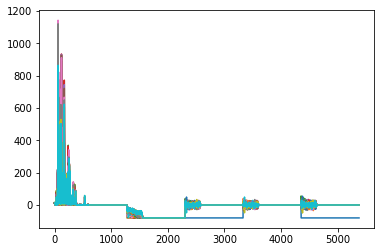

(4421, 5380)

In [3]:
import matplotlib.pyplot as plt

plt.plot(X_heli[:50, :].T)
plt.show()
X_heli.shape

## Train model

In [4]:
from sklearn.mixture import GaussianMixture as GMM

train_boat = X_boat[:-5120]
train_heli = X_heli[:-5120]
test_boat = X_boat[-5120:]
test_heli = X_heli[-5120:]

gmm = {'boat':None, 'heli':None}

gmm["boat"] = GMM(n_components=2)
gmm["boat"].fit(train_boat)

gmm["heli"] = GMM(n_components=2)
gmm["heli"].fit(train_heli)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

## Predict

In [5]:
test_full = np.concatenate((test_boat, test_heli), axis = 0)
test_labels = np.concatenate((np.zeros((test_boat.shape[0], 1)), np.ones((test_heli.shape[0], 1))), axis = 0)

scores = np.zeros((test_full.shape[0], 2))

scores[:, 0] = gmm["boat"].score_samples(test_full)
scores[:, 1] = gmm["heli"].score_samples(test_full)

pred = np.greater(scores[:, 1], scores[:, 0])
error = np.not_equal(pred, np.squeeze(test_labels))

error_rate = np.sum(error) / len(error)
print(error_rate)

0.27216796875
